# LangGraph Travel Advisor

## Import

In [ ]:
# Install required packages
%pip install -qU bs4
%pip install -qU chromadb
%pip install -qU tiktoken
%pip install -qU langchain
%pip install -qU langgraph
%pip install -qU langchainhub
%pip install -qU tavily-python
%pip install -qU "nomic[local]"
%pip install -qU langchain-nomic
%pip install -qU langchain-ollama
%pip install -qU langchain_community


In [ ]:
# Import
import os
import re
import getpass
import operator
import requests

from bs4 import BeautifulSoup
from urllib.parse import urljoin
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from typing import Annotated, List, Literal

# from langchain import hub
from langchain.schema import Document
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph

import warnings
warnings.filterwarnings("ignore")


In [3]:
# # Constants

# URL to crawl to data retrieval
EN_URL = "https://www.italia.it/en"  

# Regions List for URLs
REGIONS = [
    "abruzzo", "aosta-valley", "puglia", "basilicata", "calabria", "campania", "emilia-romagna", 
    "friuli-venezia-giulia", "lazio", "liguria", "lombardy", "marche", "molise", "piedmont", 
    "sardinia", "sicily", "south-tyrol", "trentino", "tuscany", "umbria", "veneto"
]

test_travel_query = [
    "What are the must-visit historical landmarks in Tuscany, and how can I plan a week-long trip around them?",
    "What are the best hiking trails in the Dolomites, and how should I prepare for a trip in South Tyrol?",
    "Which coastal towns in Liguria offer the best seafood and picturesque beaches for a relaxing vacation?",
    "What unique local festivals should I explore in Sicily during the summer, and how can I immerse myself in the culture?",
    "How can I plan an itinerary through Umbria to experience its medieval towns and wine tours?",
    "What are the top tourist attractions to explore in Kyoto, Japan, during the cherry blossom season?",
    "What are the best islands to visit in the Maldives for honeymooners seeking a secluded getaway?",
    "How can I plan a wildlife safari in Kenya, including the best national parks to visit and ideal travel months?",
    "What are the must-see natural wonders in Iceland for a 10-day road trip around the island?",
    "Which cities in New Zealand offer the best adventure activities, from bungee jumping to glacier hikes?",
]

test_general_query = [
    "How does artificial intelligence impact job automation, and what industries are most affected by this shift?",
    "What are the key differences between renewable energy sources like solar and wind, and how do they contribute to reducing carbon emissions?",
    "What role does social media play in shaping public opinion, and how can it influence political movements?",
    "What are the psychological effects of long-term isolation, and how can individuals maintain mental well-being in such conditions?",
    "How do global supply chain disruptions affect the economy, and what strategies can businesses use to mitigate risks?",
]


## APIs

In [4]:
# Setup environment 
def _set_env(key: str) -> None:
    """
    Set the environment variables.
        Args:
            key (str): The name of the environment variable.
    """
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"Enter {key}:")

# Nomic and Tavily APIs 
_set_env("NOMIC_API_KEY")
_set_env("TAVILY_API_KEY")


In [5]:
# # Model & Tool
# LLM 
local_llm = "llama3.2"  
llm = ChatOllama(model=local_llm, temperature=0)

# Initialize Tavily web search tool
tavily_web_search = TavilySearchResults(max_results=3)


## Get Data

In [6]:
# retrieve internal links from a webpage 
def get_internal_links(home_url: str, max_links: int = 5) -> List[str]:
    """
        Retrieves internal links from the given webpage URL.
    
        Args:
            - website_url: The URL of the webpage to crawl.
            - max_links: The maximum number of URLs to retrieve (default is 5).
        Returns:
            A list of internal URLs.
    """
    # Send a request to the website
    response = requests.get(home_url)
    
    # Parse the content of the webpage
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Set of internal links
    internal_links = set()
    
    # Find all <a> tags with href attributes
    for link in soup.find_all("a", href=True):
        # Convert relative URLs to absolute URLs
        href = urljoin(home_url, link["href"])
        
        # Check if the URL starts with the base URL
        if href.startswith(home_url) and '#' not in href:
            internal_links.add(href)
        
        # Stop if we have enough links
        if len(internal_links) >= max_links:
            break
    
    return list(internal_links)


# internal urls
urls = []
# Craw internal URLs
for region in REGIONS:
    base_url = f"{EN_URL}/{region}"  # URL for each region
    internal_urls = get_internal_links(home_url=base_url) # Get internal URLs 
    urls.extend(internal_urls)

counter = 0
# Print all internal URLs from all regions
for internal_url in urls:
    counter += 1
    print(internal_url)

print(f"Counter: {counter}")

https://www.italia.it/en/abruzzo
https://www.italia.it/en/abruzzo/teramo
https://www.italia.it/en/abruzzo/pescara
https://www.italia.it/en/abruzzo/l-aquila
https://www.italia.it/en/abruzzo/chieti
https://www.italia.it/en/aosta-valley
https://www.italia.it/en/aosta-valley/courmayeur-style-and-tradition
https://www.italia.it/en/aosta-valley/aosta
https://www.italia.it/en/aosta-valley/things-to-do/aosta-valley-castles
https://www.italia.it/en/aosta-valley/things-to-do/spas-wellness-holidays-aosta-valley
https://www.italia.it/en/puglia/foggia
https://www.italia.it/en/puglia
https://www.italia.it/en/puglia/barletta-andria-trani
https://www.italia.it/en/puglia/bari
https://www.italia.it/en/puglia/gargano
https://www.italia.it/en/basilicata/potenza
https://www.italia.it/en/basilicata/matera
https://www.italia.it/en/basilicata/things-to-do/basilicata-itineraries
https://www.italia.it/en/basilicata
https://www.italia.it/en/basilicata/matera/things-to-do/matera-the-sassi
https://www.italia.it/en

## Vectorstore

In [7]:
# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

# Set embeddings
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")

# Add to vectorstore
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embeddings)

# Create retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})


In [8]:
# Test retriever
retrieved_docs = retriever.invoke("Duomo")
print(retrieved_docs)


[Document(metadata={'description': 'From The Last Supper to Milan Cathedral, discover the things to see and do in Milan. Visit the city of fashion and design.', 'language': 'en', 'source': 'https://www.italia.it/en/lombardy/milan', 'title': 'Milan: Things to do & Attractions to visit - Italia.it'}, page_content='The most famous and important square in Milan\nIt is impossible to travel to Milan and not pass through Piazza Duomo, the central square of the city. With its square shape, it is one of the largest in Italy, and an ideal place to start a tour. It is towered over by the Duomo, "Domm" in Milanese, the Gothic style cathedral with spires that is the icon of the Lombardy’s capital. A visit to the Duomo Museum, housed in the halls of the Royal Palace, is recommended. At the center of the square is the monument dedicated to Vittorio Emanuele II, an equestrian statue in bronze, representing the King intent on rein in his horse.\nA stop at the Galleria Vittorio Emanuele II with its larg

## Components

### Query is Relevant?

In [9]:
class QueryIsRelevant(BaseModel):
    """
      Verify if the query is relevant to the topic of travel or not.
    """
    subject: Literal["travel", "other"] = Field(
        description="Given a user question choose to route it to 'travel' or 'other'."
    )
    
# LLM
structured_llm_relevant = llm.with_structured_output(QueryIsRelevant)

# System prompt
relevant_instructions = """You are an expert at evaluating the topics of a user question.
Use 'travel' if the question concern the topics and concepts related to travel and tourism. Otherwise, use 'other'.
"""

# Combine the system message and user question in a prompt template
relevant_query_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", relevant_instructions),
        ("human", "{question}"),
    ]
)
relevant_query = relevant_query_prompt | structured_llm_relevant


In [10]:
# # Test relevance
# expected result: vectorstore
relevant_1 = relevant_query.invoke({ 
    "question": "Where is the Colosseum?"
})
print(relevant_1)

# expected result: web_search
relevant_2 = relevant_query.invoke({ 
    "question": "What is the capital of France?"
})
print(relevant_2)


subject='travel'
subject='other'


### Router

In [11]:
## Router
class QueryRoute(BaseModel):
    """
      Route a user query to the most relevant datasource -> vectorstore or websearch.
    """
    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM
structured_llm_router = llm.with_structured_output(QueryRoute)

# System prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to some famous italian city, touristic and historical places, food and travel tips for tourists.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Combine the system message and user question in a prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_instructions),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router


In [12]:
# # Test router
# expected result: vectorstore
router_1 = question_router.invoke({ 
    "question": "Where is the Colosseum?"
})
print(router_1)

# expected result: web_search
router_2 = question_router.invoke({ 
    "question": "Where is the Eiffel tower?"
})
print(router_2)


datasource='vectorstore'
datasource='web_search'


### Docs Relevance

In [49]:
# Docs are relevant or not
class GradeDocs(BaseModel):
    """
        Binary score for relevance check on retrieved documents.
    """
    relevance: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM
structured_llm_retrieval = llm.with_structured_output(GradeDocs)

# System prompt
doc_grader_instructions = """
You are a grader assessing relevance of a retrieved document to a user question.  
If the document contains keyword(s), shares concepts or semantic meaning related to the user question, grade it as relevant. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", doc_grader_instructions),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_retrieval


In [50]:
# # Test grader
# First question: expected score = yes
question_1 = "Where is the Colosseum?" 
retrieve_document_1 = retriever.invoke(question_1)
docs_text_1 = retrieve_document_1[0]
print(retrieval_grader.invoke({"question": question_1, "document": docs_text_1}))

# Second question: expected score = no
question_2 = "Where is the Eiffel tower?"   
retrieve_document_2 = retriever.invoke(question_2) 
docs_text_2 = retrieve_document_2[0]
print(retrieval_grader.invoke({"question": question_2, "document": docs_text_2}))


relevance='yes'
relevance='no'


### Summarize Docs

In [16]:
# Post-processing
def format_docs(documents):
    """
    Formats and cleans the page contents of documents into a single string.

    Args:
        documents (list): A list of document objects, each containing a 'page_content' attribute.

    Returns:
        str: A single cleaned string containing the combined page contents,
              with excessive whitespace removed.
    """
    # Combine page contents
    combined_text = "\n\n".join(doc.page_content for doc in documents)

    # Clean the combined text by removing excessive whitespace
    cleaned_text = re.sub(r'\s+', ' ', combined_text).strip()

    return cleaned_text


In [17]:
# System prompt
summarization_instructions = """
You are a travel summarization assistant. Your task is to summarize the given document in a concise way, 
highlighting the core concepts and key information about travel topics. 
Ensure that the response is optimized for brevity while keeping all important information.
"""

# Define the summarization prompt template
summarization_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", summarization_instructions),
        (
            "human",
            "Here is the document text to summarize: \n\n {documents} \n Provide a concise summary.",
        ),
    ]
)

# Create the summarization chain
summarizer_chain = summarization_prompt | llm | StrOutputParser()


In [18]:
# # Test summarize
docs_txt = format_docs(retrieve_document_1)
docs_summary = summarizer_chain.invoke({
    "documents": docs_txt
})
print(docs_summary)


Here's a concise summary of the document:

**Rome and Italy**

* Colosseum: one of the 7 Wonders of the World, a must-see for anyone visiting Rome
* Roman Forum: a futuristic district with modern architecture and historical sites like the Palace of Roman Civilization
* Campo de' Fiori: a historic neighborhood market in Rome

**UNESCO Sites**

* Pompeii, Herculaneum, and Torre Annunziata: an archaeological area near Naples that lets you travel back in time
* Pantheon: one of the best-preserved Roman monuments in the world with a unique hemispherical dome

**Other Destinations**

* Crotone: an ancient Greek colony with unspoilt nature, culture, and tradition; visit the Cathedral of Santa Maria Assunta and Capo Colonna archaeological site
* Vibo Valentia: a charming town near the Ionian Sea with red-sand beaches and a Marine Protected Area

**Key Information**

* Rome has numerous museums, including the Luigi Pigorini National Museum of Prehistory and Ethnography
* The Pantheon is famous 

### Planning

In [24]:
# System prompt
planner_instructions = """
You are an expert travel planner with a kind and friendly personality. Always start the conversation by saying hello. You're excited to help travelers plan their perfect vacation with engaging and heartfelt recommendations. Present the information as if you are talking to a friend, making sure to be warm, conversational, and enthusiastic about the places to visit, the local cuisine, and tips for the trip. Make it feel like a personal guide. Don't be concise, but be conversational.

Question: {question}
Context: {context}

Plan:
- **Places to Visit**: 
    Start by warmly describing the main attractions, what makes them special, and why they're must-sees. Use friendly language like "You’ll love visiting..." or "Make sure to check out..."
    
- **Recommended Itineraries**: 
    Suggest possible itineraries that would help travelers make the most of their time. Use phrases like "If you have 3 days, I recommend starting with..." or "For a week-long trip, here's how you could plan each day..." to give them flexible but structured options.
    
- **Local Cuisine**: 
    Describe the local dishes with enthusiasm, like you're sharing a favorite meal with a friend. Phrases like "You can't leave without trying..." or "One bite of this and you'll see why it's a local favorite..." will make it feel personal.

- **Tips for Travelers**: 
    Offer helpful advice as if you're giving insider knowledge, with kind reminders like "Don’t forget to bring..." or "It's always good to know that..."

End with a friendly closing note like: "I hope you have an amazing time! Safe travels!"
"""
planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", planner_instructions),
        ("human", "Question: \n\n {question}"),
    ]
)
plan_chain = planner_prompt | llm | StrOutputParser()


In [34]:
# Test planner
planner_docs = retriever.invoke(question_1)
planner_docs_txt = format_docs(planner_docs)

generated_plan = plan_chain.invoke({
    "context": docs_summary, 
    "question": question_1,
})
print(generated_plan)


Hello! I'm so excited to help you plan your trip!

The Colosseum, one of the most iconic landmarks in Rome, Italy, is actually located in the heart of the city. You can't miss it! It's situated in the center of the Roman Forum, which was once the main hub of ancient Rome.

Imagine walking through the cobblestone streets of Rome and suddenly, you're standing in front of this incredible ancient amphitheater. The Colosseum is an engineering marvel that could hold up to 50,000 spectators during gladiator battles, animal hunts, and even re-enactments of famous battles. It's truly awe-inspiring!

You'll love visiting the Colosseum because it's steeped in history and offers a glimpse into ancient Rome's grandeur. Take a guided tour to learn more about its construction, the emperors who ruled from here, and the events that took place within its walls.

Make sure to check out the surrounding Roman Forum, which is also filled with ancient ruins, temples, and basilicas. It's like stepping back in

### Check for hallucination

In [39]:
# Hallucination Grader
class GradeHallucinations(BaseModel):
    """
        Binary score for hallucination present in planner answer.
    """

    coherence: str = Field(
        description="Answer is consistent with the documents, 'yes' or 'no'"
    )
    
# LLM
structured_llm_hallucination = llm.with_structured_output(GradeHallucinations)

# System prompt
hallucination_instructions = """
You are a rater who evaluates whether the planner is consistent with the information in the documents. 
You assign a binary score of "yes" or "no". "yes" means the answer is consistent with the documents."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_instructions),
        ("human", "documents: \n\n {documents} \n\n planner: {planner}"),
    ]
)
hallucination_grader = hallucination_prompt | structured_llm_hallucination


In [38]:
# # Test hallucination
hallucination = hallucination_grader.invoke({
    "documents": docs_summary,  
    "planner": generated_plan  
})
print(hallucination)


coherence='yes'


### Answer evaluation

In [43]:
# Answer Grader
class GradeAnswers(BaseModel):
    """Binary score to assess answer addresses question."""

    evaluation: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
    
# LLM
structured_llm_grader = llm.with_structured_output(GradeAnswers)

# System prompt
answer_grader_instructions = """
You are a grader assessing whether the planner addresses / resolves a request
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the request."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_instructions),
        ("human", "User question: \n\n {question} \n\n Planner: {planner}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader


In [44]:
# # Test grade answer
grade_answer = answer_grader.invoke({
    "question": question_1, 
    "planner": generated_plan
})
print(grade_answer)

evaluation='yes'


### Re-write query

In [45]:
# System prompt
re_write_instructions = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", re_write_instructions),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [46]:
# Test question re-writer 
question_rewriter.invoke({"question": question_1})


'Improved Question:\nWhat is the location of the ancient Roman amphitheater known as the Colosseum?\n\nReasoning:\n\n1. **Specificity**: The original question is quite general, asking for a location without specifying which one (e.g., Rome, Italy). The improved question adds specificity by mentioning "the ancient Roman amphitheater," which helps to narrow down the search results.\n2. **Contextualization**: By adding "ancient Roman" and "amphitheater," we provide more context about what is being asked. This can help the vector store retrieve a more accurate result, as it\'s clear that we\'re looking for information about a specific historical landmark.\n3. **Precision**: The phrase "known as the Colosseum" adds precision to the question, making it clear that we\'re referring to this particular structure rather than another similar one.\n\nBy rephrasing the question in this way, we\'ve made it more informative and targeted, which can lead to better retrieval results from a vector store.'

# Tavily: web search tool

In [47]:
# Test Tavily 
tavily_web_search.invoke({"query": "What is the answer to the ultimate question of life, the universe, and everything?"})


[{'url': 'https://simple.wikipedia.org/wiki/42_(answer)',
  'content': '42 (answer) 42 is the "Answer to the Ultimate Question of Life, the Universe, and Everything" in The Hitchhiker\'s Guide to the Galaxy books. It was computed by Deep Thought, the second greatest computer ever. [1] The descendants of Deep Thought\'s creators are upset by the numeric nature of the answer, not understanding what to do with it or'},
 {'url': 'https://news.mit.edu/2019/answer-life-universe-and-everything-sum-three-cubes-mathematics-0910',
  'content': 'Suggestions or feedback?\nMIT News | Massachusetts Institute of Technology\nBrowse By\nTopics\nDepartments\nCenters, Labs, & Programs\nSchools\nThe answer to life, the universe, and everything\nPress Contact:\nPrevious image\nNext image\nA team led by Andrew Sutherland of MIT and Andrew Booker of Bristol University has solved the final piece of a famous 65-year old math puzzle with an answer for the most elusive number of all: 42.\n The method of using Ch

## Graph: State

In [225]:
# Graph's state
class State(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        documents: list of documents.
        max_retries: the maximum number of hallucination checks permitted.
        loop_step: Indicates the current step in a looping process.
        planner: LLM planning.
        question: question.
        web_search: run web search
    """
    documents: List[str]
    max_retries: int
    loop_step: Annotated[int, operator.add]
    planner: str
    route: str
    topic: str
    question: str
    web_search: str
    

### Graph: Nodes

In [258]:
# Node: query subject
def subject(state: State) -> dict:
    """
        Get the subject of the user query
        Args:
            state: The current graph state 
        Returns:
            Updates subject key based on the user query
    """
    print("---ESTABLISH SUBJECT---")
    question = state["question"]
    
    subject_score = relevant_query.invoke({
        "question": question
    })
    # Return state
    return {"topic": subject_score, "question": question}


# Node: off-topic response
def llm_standard_response(state: State) -> dict:
    """
    Responds with a standard message.

    Args:
        The current state of the graph.

    Returns:
        Updates planner key.
    """
    # Standard response message to inform the user.
    standard_response = (
        "Hello! I'm your travel assistant, and I can help with questions related to travel."
    )
    # Update the state
    state["planner"] = standard_response
    
    # Return state 
    return {"planner": state["planner"]}


# Node: query route
def router(state: State) -> dict:
    """
        Get the route of the user query
    
        Args:
            state (dict): The current graph state
    
        Returns:
            Updates route key based on the relevant user query
    """
    print("---ESTABLISH ROUTE---")
    question = state["question"]
    
    route_score = question_router.invoke({
        "question": question
    }) 
    # Return state
    return {"route": route_score, "question": question}

    
# Node: retrieve documents
def retrieve(state: State) -> dict:
    """
        Retrieve documents from vectorstore
    
        Args:
            state: The current graph state
    
        Returns:
            state: Updates documents key with only filtered relevant documents
    """
    print("---RETRIEVE DOCS---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    
    return {"documents": documents, "question": question}


# Node: docs are relevant or not
def grade_documents(state: State) -> dict:
    """
        Determines whether the retrieved documents are relevant to the question.
    
        Args:
            state: The current graph state
    
        Returns:
            state: Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE---")
    question = state["question"]    
    documents = state["documents"] 

    relevant_documents = []
    select_web= "NO"
    yes_count = 0
    
    for doc in documents:
        retrieval_score = retrieval_grader.invoke({
            "question": question, 
            "document": doc.page_content
        })
        retrieval_grade = retrieval_score.relevance
        
        if retrieval_grade == "yes":
            print("---DOCUMENT RELEVANCE---")
            relevant_documents.append(doc)
            yes_count += 1
        else:
            print("---DOCUMENT NOT RELEVANCE---")
            # select_web = "yes"
            continue
            
    # Set web_search to "yes" only if the majority of docs are graded as "no"
    total_docs = len(documents)
    if yes_count <= total_docs // 2:
        select_web = "YES"
    
    return {"documents": relevant_documents, "web_search": select_web}


# # Node: Summarize Documents
# def summarize_documents(state: State) -> dict:
#     """
#     Summarizes the relevant documents for easier planning and evaluation.
#     
#     Args:
#         state: The current graph state.
#     
#     Returns:
#         state: Updates documents key with the summarized content.
#     """
#     print("---SUMMARIZE DOCUMENTS---")
#     documents = state["documents"]
#     
#     # Combine documents into a single text block for summarization
#     document_text = format_docs(documents)
#     
#     # Summarize the documents
#     summarized_docs = summarizer_chain.run({"documents": document_text})
#     
#     return {"documents": summarized_docs}


# # Node: make query great again
# def transform_query(state: State) -> dict:
#     """
#         Transform the query to produce a better question.
#     
#         Args:
#             state (dict): The current graph state
#     
#         Returns:
#             state (dict): Updates question key with a re-phrased question
#     """
#     print("---TRANSFORM QUERY---")
#     question = state["question"]
#     documents = state["documents"]
# 
#     # Re-write question
#     better_question = question_rewriter.invoke({"question": question})
#     
#     return {"documents": documents, "question": better_question}


# Node: planning
def planner(state: State) -> dict:
    """
        Generates a plan based on the provided query.
        
        Args:
            state (dict): The current graph state.
    
        Returns:
            state (dict): Updates planner key with the generated plan and
                the loop step, incremented by 1.
    """
    print("---PLANNER---")
    question = state["question"]            # Get question state
    documents = state["documents"]          # Get documents state
    loop_step = state.get("loop_step", 0)   # Get loop_step state
    
    # RAG planning
    make_plan = plan_chain.invoke({
        "context": documents,
        "question": question
    })
    # Return state
    return {"documents": documents, "question": question, "planner": make_plan, "loop_step": loop_step + 1}


# Node: search on the web
def web_search(state: State) -> dict:
    """
    Web search based on the query.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]          
    documents = state.get("documents", []) 

    # Perform a web search using the Tavily
    web_docs = tavily_web_search.invoke({"query": question})
    web_results = "\n".join([doc["content"] for doc in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    # Return state
    return {"documents": documents, "question": question}
    

### Graph: Edges

In [259]:
# Edge: 'off-topic' or 'on-topic'
def route_subject(state: State) -> str:
    """
        Route question to travel or other.
    
        Args:
            state (dict): The current graph state

        Returns:
            str: Next node to call
    """
    topic = state["topic"]
    topic_grade = topic.subject
    
    # Determine if subject is off-topic or not
    if topic_grade == "other":
        print("===SUBJECT: OTHER===")
        return "off-topic"
    elif topic_grade == "travel":
        print("===SUBJECT: TRAVEL===")
        return "on-topic"
    
    
# Edge: RAG or web
def route_question(state: State) -> str:
    """
        Route question to web search or RAG.
    
        Args:
            state (dict): The current graph state

        Returns:
            str: Next node to call
    """
    source = state["route"]
    source_grade = source.datasource
    
    # Decide if route to 'web_search' or 'vectorstore'
    if source_grade == "web_search": 
        print("===ROUTE: WEB SEARCH===")
        return "websearch"    
    elif source_grade == "vectorstore":
        print("===ROUTE: RAG===")
        return "vectorstore"
    

# Edge: planner or web_search
def decide_to_plan(state: State) -> str:
    """
    Determines whether start planning, or search answer on the web.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("===EVALUATE GRADED DOCUMENTS===")
    # question = state["question"]
    go_to_web = state["web_search"]
    # filtered_documents = state["documents"]
    
    if go_to_web == "YES":
        print("===DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH===")
        return "websearch"
    else: 
        print("===DECISION: PLANNER===")
        return "travel_planner"


# Edge: fact checking on docs
def grade_generation_v_documents_and_question(state: State) -> str:
    """
    Determines whether the planning is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("===CHECK HALLUCINATIONS===")
    question = state["question"]
    documents = state["documents"]
    loop_step = state["loop_step"]
    max_retries = state.get("max_retries", 3)
    plan = state["planner"]
    
    hallucination_score = hallucination_grader.invoke({
        "documents": format_docs(documents), 
        "planner": plan
    })
    hallucination_grade = hallucination_score.coherence
    
    # Check hallucination
    if hallucination_grade == "yes":
        print("===DECISION: PLANNER IS GROUNDED IN DOCUMENTS===")
        
        # Check question-answering
        print("===GRADE PLANNER vs QUESTION===")
        answer_score = answer_grader.invoke({
            "question": question,
            "planner": plan
        })
        answer_grade = answer_score.evaluation 
        
        if answer_grade == "yes":
            print("===DECISION: PLANNER ADDRESSES QUESTION===")
            return "useful"
        elif loop_step <= max_retries:
            print("===DECISION: PLANNER DOES NOT ADDRESS QUESTION===")
            return "not useful"
        else:
            print("===DECISION: MAX RETRIES REACHED===")
            return "max retries"
    elif loop_step <= max_retries:
        print(f"===DECISION: PLANNER IS NOT GROUNDED IN DOCUMENTS, RE-TRY===")
        return "check"
    else:
        print("===DECISION: MAX RETRIES REACHED===")
        return "max retries"


### Build the graph

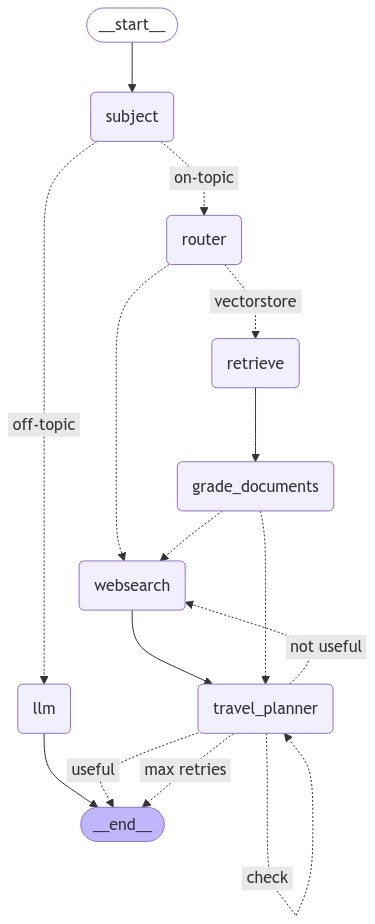

In [261]:
# Graph's state
workflow = StateGraph(State)

# Define the nodes
workflow.add_node(node="subject", action=subject)
workflow.add_node(node="llm", action=llm_standard_response)
workflow.add_node(node="router", action=router)                     
workflow.add_node(node="retrieve", action=retrieve)                 
workflow.add_node(node="grade_documents", action=grade_documents)   
workflow.add_node(node="websearch", action=web_search)              
workflow.add_node(node="travel_planner", action=planner)           

# Build graph: edges and condition
workflow.add_edge(START, "subject")
workflow.add_conditional_edges(
    "subject",
    route_subject,
    {
        "on-topic": "router",
        "off-topic": "llm",
    }
)
workflow.add_edge("llm", END)

workflow.add_conditional_edges(
    "router",
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("websearch", "travel_planner")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_plan,
    {
        "websearch": "websearch",
        "travel_planner": "travel_planner",
    },
)

workflow.add_conditional_edges(
    "travel_planner",
    grade_generation_v_documents_and_question,
    {
        "check": "travel_planner",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
# Display the graph
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [262]:
# Test Graph
answer = graph.invoke({"question":"Hi, I'd like to plan a vacation in Italy, in the Sardinia region. What do you suggest me?"})["planner"]
print(f"Final state: {answer}")


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
===EVALUATE GRADED DOCUMENTS===
===DECISION: PLANNER===
---PLANNER---
===CHECK HALLUCINATIONS===
===DECISION: PLANNER IS GROUNDED IN DOCUMENTS===
===GRADE PLANNER vs QUESTION===
===DECISION: PLANNER ADDRESSES QUESTION===
Final state: Italy, and specifically Sardinia, is one of my favorite destinations! You're going to have an amazing time exploring this beautiful island.

Let's start with some must-see places. You'll love visiting the stunning beaches like La Pelosa in Stintino, known for its crystal-clear waters and white sand. Or head to Chia Beach, which offers breathtaking views of the Mediterranean Sea. If you're looking for something a bit more adventurous, visit the Grotta di Nettuno, a natural sea cave that's perfect 

In [263]:
# Test Graph
answer = graph.invoke({"question":"Hi, I'd like to plan a vacation in Italy, in the Sardinia region. What do you suggest me?"})["planner"]
print(answer)


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
===EVALUATE GRADED DOCUMENTS===
===DECISION: PLANNER===
---PLANNER---
===CHECK HALLUCINATIONS===
===DECISION: PLANNER IS GROUNDED IN DOCUMENTS===
===GRADE PLANNER vs QUESTION===
===DECISION: PLANNER ADDRESSES QUESTION===
Italy, and specifically Sardinia, is one of my favorite destinations! You're going to have an amazing time exploring this beautiful island.

Let's start with some must-see places. You'll love visiting the stunning beaches like La Pelosa in Stintino, known for its crystal-clear waters and white sand. Or head to Chia Beach, which offers breathtaking views of the Mediterranean Sea. If you're looking for something a bit more adventurous, visit the Grotta di Nettuno, a natural sea cave that's perfect for snorkelin

In [265]:
# Test Graph
answer = graph.invoke({"question":"Who won the Olympics 2024?"})["planner"]
print(answer)

---ESTABLISH SUBJECT---
===SUBJECT: OTHER===
Hello! I'm your travel assistant, and I can help with questions related to travel.


In [266]:
# Test Graph
answer = graph.invoke({"question":"Define an itinerary for the Aosta-valley region?"})["planner"]
print(answer)


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
===EVALUATE GRADED DOCUMENTS===
===DECISION: PLANNER===
---PLANNER---
===CHECK HALLUCINATIONS===
===DECISION: PLANNER IS GROUNDED IN DOCUMENTS===
===GRADE PLANNER vs QUESTION===
===DECISION: PLANNER ADDRESSES QUESTION===
The Aosta Valley is a beautiful region in northwest Italy, known for its stunning mountain scenery, rich history, and vibrant culture. Here's a suggested 7-day itinerary for exploring the Aosta Valley:

Day 1: Arrival in Aosta and Exploration of the City

* Arrive in Aosta, the capital city of the valley
* Visit the Roman ruins of Augustus' Palace and the Cathedral of S. Lorenzo
* Explore the historic center, including the Piazza Principe and the Palazzo Ducale
* Enjoy traditional Aosta Valley cuisine for dinner


In [268]:
# Test Graph: expected generation NOT grounded in docs
answer = graph.invoke({"question":"What kind of food I can eat while visiting Paris?"})["planner"]
print(answer)


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---ESTABLISH ROUTE---
===ROUTE: WEB SEARCH===
---WEB SEARCH---
---PLANNER---
===CHECK HALLUCINATIONS===
===DECISION: PLANNER IS GROUNDED IN DOCUMENTS===
===GRADE PLANNER vs QUESTION===
===DECISION: PLANNER ADDRESSES QUESTION===
Hello! Oh, I'm so excited to talk about the food in Paris! You're going to love it - it's truly one of the best culinary experiences in the world. From classic French dishes to delicious pastries and sweet treats, you'll find something to satisfy every craving.

First of all, let's start with the quintessential French dish: Coq au Vin. This classic recipe originated in the Burgundy region, but you can find it on menus throughout Paris. It's a must-try for any foodie visiting the city. The combination of tender chicken cooked in red wine with mushrooms and bacon is absolute perfection.

Of course, no trip to Paris would be complete without trying some delicious French bread and cheese. You'll find croque-monsieur sand

## 